#### Loading Packages

In [2]:
import pandas as pd
import numpy as np

# Plotting
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
import seaborn as sns

# Utilities
import sys
import os

# Statsmodels
import statsmodels.api as sm
from statsmodels.tools import add_constant

# Sklearn modules
from sklearn.linear_model import LogisticRegressionCV, LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score, roc_curve, make_scorer, confusion_matrix, accuracy_score, recall_score
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier

In [3]:
project_root = os.path.abspath('..')

# Adding the project root to my system path
if project_root not in sys.path:
    sys.path.append(project_root)

from src.data_loader import telco_data_loader
from src.data_processor import telcoDataCleaner

/Users/samueljoseph/Documents/Programming/telco-customer-churn/venv/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


#### Loading and cleaning data

In [4]:
# running the loader
raw_telco_data = telco_data_loader()

cleaner = telcoDataCleaner()

cleaned_data = cleaner.clean_data(raw_telco_data)

src.data_loader - Starting download of telco data
src.data_loader - Telco data download successful
src.data_loader - CSV data downloaded successfully
src.data_processor - Binary columns converted
src.data_processor - Converting gender
src.data_processor - Converting Internet Service
src.data_processor - Converting Multiple Lines
src.data_processor - Created dummy columns for Contract and Payment Method
src.data_processor - Data types successfully converted
src.data_processor - Outlier Summary: {}
src.data_processor - Columns with missing values: {'OnlineSecurity': np.int64(1526), 'OnlineBackup': np.int64(1526), 'DeviceProtection': np.int64(1526), 'TechSupport': np.int64(1526), 'StreamingTV': np.int64(1526), 'StreamingMovies': np.int64(1526), 'TotalCharges': np.int64(11)}
src.data_processor - Filled missing values in TotalCharges with medians
src.data_processor - Filled missing values in Churn with medians


## Testing Models

Data prep

In [5]:
# identifying predeictors columns with NA's

# Only selecting columns that aren't missing values
non_na_cols = []

for col in cleaned_data['predictors']:
    if cleaned_data['predictors'][col].isna().sum() == 0:
        non_na_cols.append(col)

# Adding constant to the predictors
reg_predictors = add_constant(cleaned_data['predictors'].copy(),
                              has_constant = 'raise',
                              prepend = True)

##### Statistical Modeling

Performing regressions with the statistical model first to understand the impact of predictors.

In [6]:
online_log_reg_model = sm.Logit(endog = cleaned_data['target'][cleaned_data["masks"]],
                         exog = reg_predictors.loc[cleaned_data["masks"], :]).fit()

Optimization terminated successfully.
         Current function value: 0.470717
         Iterations 7


In [7]:
print(online_log_reg_model.summary())

                           Logit Regression Results                           
Dep. Variable:                  Churn   No. Observations:                 5517
Model:                          Logit   Df Residuals:                     5494
Method:                           MLE   Df Model:                           22
Date:                Sat, 06 Sep 2025   Pseudo R-squ.:                  0.2475
Time:                        06:08:31   Log-Likelihood:                -2596.9
converged:                       True   LL-Null:                       -3451.3
Covariance Type:            nonrobust   LLR p-value:                     0.000
                                            coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------
const                                    -0.6645      0.217     -3.061      0.002      -1.090      -0.239
gender                                   -0.0106  

In [8]:
cols_to_exclude = non_na_cols.copy()

cols_to_exclude.remove("InternetService")

nol_log_reg_model = sm.Logit(endog = cleaned_data['target'][~np.array(cleaned_data["masks"])],
                             exog = reg_predictors.loc[~np.array(cleaned_data["masks"]), cols_to_exclude]).fit()

Optimization terminated successfully.
         Current function value: 0.203968
         Iterations 9


In [9]:
print(nol_log_reg_model.summary())

                           Logit Regression Results                           
Dep. Variable:                  Churn   No. Observations:                 1526
Model:                          Logit   Df Residuals:                     1511
Method:                           MLE   Df Model:                           14
Date:                Sat, 06 Sep 2025   Pseudo R-squ.:                  0.2274
Time:                        06:08:31   Log-Likelihood:                -311.26
converged:                       True   LL-Null:                       -402.85
Covariance Type:            nonrobust   LLR p-value:                 1.459e-31
                                            coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------
gender                                   -0.0860      0.213     -0.404      0.686      -0.503       0.331
SeniorCitizen                             0.7025  

## Switching to ML

### Internet Customers Model

In [10]:
internet_target = cleaned_data['target'][cleaned_data["masks"]]
internet_preds = reg_predictors.loc[cleaned_data["masks"], :]

Writing a custom loss function to reflect the tradeoff of customer churn vs. outreach

In [11]:
# Custom loss function
def churn_loss(y_true, y_pred):
    '''Custom scoring function to represent the business cost of churned customers.
       Weights are dependent on the cost of customer acquisition.
       Assumption is a churned customer is worth ~6 months of average revenue, 
       while interventions cost 2 months of average revenue. Therefore the relative payoff weights are 3:1'''

    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    cost = (fn * 3) + (fp * 1)
    return -cost

# Making a custom loss scorer
churn_loss_scorer = make_scorer(churn_loss)
        

In [12]:
# Scaling Data
scaler = StandardScaler()

internet_preds_for_model = scaler.fit_transform(internet_preds)

# Initiating Class of LogisticRegressionCV
log_reg_cv = LogisticRegressionCV(cv = 5, 
                                  max_iter = 10000, 
                                  random_state=42,
                                  scoring = churn_loss_scorer)

# Fitting the regression
log_reg_cv.fit(X = internet_preds, 
               y = internet_target)

,Cs,10
,fit_intercept,True
,cv,5
,dual,False
,penalty,'l2'
,scoring,make_scorer(c...hod='predict')
,solver,'lbfgs'
,tol,0.0001
,max_iter,10000
,class_weight,None
,n_jobs,None


### Grid Searching

#### Logistic Regression

In [13]:
# Setting up the parameter grid
log_reg_param_grid = {'C': np.linspace(start = 0.1, stop = 1, num = 10),
                      'penalty' : ['l1', 'l2']}



# Initializing a LogisticRegression class
log_reg_gs = GridSearchCV(LogisticRegression(max_iter = 10000,
                                             solver = 'liblinear'),
                          scoring= {"churn_loss": churn_loss_scorer,
                                    "accuracy": 'accuracy',
                                   "recall": 'recall',
                                    "roc_auc": 'roc_auc'},
                          param_grid= log_reg_param_grid,
                          cv = 5,
                          refit= "churn_loss")

In [14]:
# Fitting the grid search
log_reg_gs.fit(internet_preds, internet_target)

,estimator,LogisticRegre...r='liblinear')
,param_grid,"{'C': array([0.1, 0....8, 0.9, 1. ]), 'penalty': ['l1', 'l2']}"
,scoring,"{'accuracy': 'accuracy', 'churn_loss': make_scorer(c...hod='predict'), 'recall': 'recall', 'roc_auc': 'roc_auc'}"
,n_jobs,None
,refit,'churn_loss'
,cv,5
,verbose,0
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,penalty,'l1'


In [15]:
# Getting the best parameters
print(f"Best parameters: {log_reg_gs.best_params_}")
print(f"Best score: {log_reg_gs.best_score_}")

gs_cv_results_df = pd.DataFrame(log_reg_gs.cv_results_)

Best parameters: {'C': np.float64(0.30000000000000004), 'penalty': 'l1'}
Best score: -544.2


#### Random Forest

In [16]:
# Creating a random forest parameter grid
rf_param_grid = {'n_estimators': np.arange(14, 40, 2),
                 'max_depth': np.arange(2, 20, 2)}

# Setting up the K-Fold Object
rf_gs = GridSearchCV(RandomForestClassifier(criterion='entropy',
                                            max_depth = 10),
                     param_grid= rf_param_grid,
                     cv = 5,
                     scoring= {"churn_loss": churn_loss_scorer,
                                    "accuracy": 'accuracy',
                                   "recall": 'recall',
                                    "roc_auc": 'roc_auc'},
                    refit= 'churn_loss')

In [17]:
# Fitting the Random Forest Grid
rf_gs.fit(internet_preds, internet_target)

,estimator,RandomForestC... max_depth=10)
,param_grid,"{'max_depth': array([ 2, 4..., 14, 16, 18]), 'n_estimators': array([14, 16..., 34, 36, 38])}"
,scoring,"{'accuracy': 'accuracy', 'churn_loss': make_scorer(c...hod='predict'), 'recall': 'recall', 'roc_auc': 'roc_auc'}"
,n_jobs,None
,refit,'churn_loss'
,cv,5
,verbose,0
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,n_estimators,np.int64(36)


In [18]:
print(f"Best parameters: {rf_gs.best_params_}")
print(f"Best score: {rf_gs.best_score_}")

Best parameters: {'max_depth': np.int64(10), 'n_estimators': np.int64(36)}
Best score: -580.4


In [19]:
rf_cv_results = pd.DataFrame(rf_gs.cv_results_)

rf_cv_results.columns

Index(['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time',
       'param_max_depth', 'param_n_estimators', 'params',
       'split0_test_churn_loss', 'split1_test_churn_loss',
       'split2_test_churn_loss', 'split3_test_churn_loss',
       'split4_test_churn_loss', 'mean_test_churn_loss', 'std_test_churn_loss',
       'rank_test_churn_loss', 'split0_test_accuracy', 'split1_test_accuracy',
       'split2_test_accuracy', 'split3_test_accuracy', 'split4_test_accuracy',
       'mean_test_accuracy', 'std_test_accuracy', 'rank_test_accuracy',
       'split0_test_recall', 'split1_test_recall', 'split2_test_recall',
       'split3_test_recall', 'split4_test_recall', 'mean_test_recall',
       'std_test_recall', 'rank_test_recall', 'split0_test_roc_auc',
       'split1_test_roc_auc', 'split2_test_roc_auc', 'split3_test_roc_auc',
       'split4_test_roc_auc', 'mean_test_roc_auc', 'std_test_roc_auc',
       'rank_test_roc_auc'],
      dtype='object')

Plotting results of Grid Search

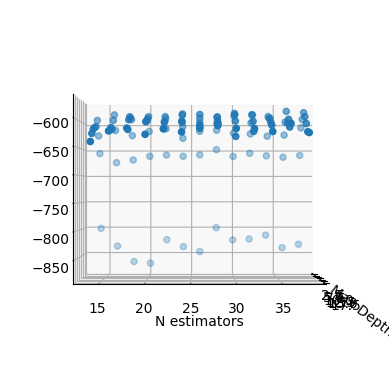

In [20]:
rf_fig = plt.figure()
rf_ax = plt.axes(projection='3d')
rf_ax.view_init(elev=0, azim=0)
rf_ax.scatter3D(rf_cv_results['param_max_depth'],
             rf_cv_results['param_n_estimators'],
             rf_cv_results['mean_test_churn_loss'])
plt.xlabel('Max Depth')
plt.ylabel('N estimators')
plt.show()

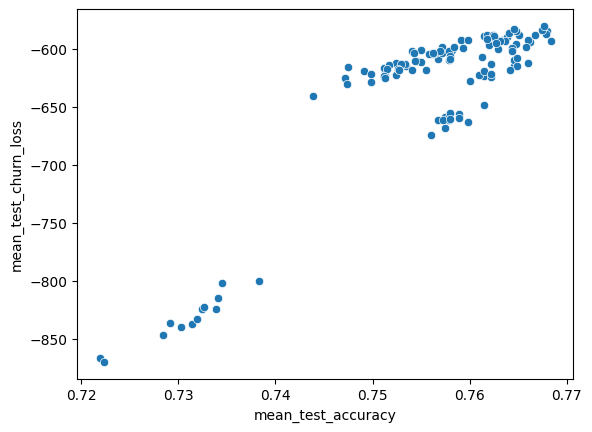

In [24]:
sns.scatterplot(data = rf_cv_results,
                x = 'mean_test_accuracy',
                y = 'mean_test_churn_loss')
plt.show()

#### SVM

In [ ]:
# Creating a random forest parameter grid
rf_param_grid = {'n_estimators': np.arange(14, 40, 2),
                 'max_depth': np.arange(2, 20, 2)}

# Setting up the K-Fold Object
rf_gs = GridSearchCV(RandomForestClassifier(criterion='entropy',
                                            max_depth = 10),
                     param_grid= rf_param_grid,
                     cv = 5,
                     scoring= {"churn_loss": churn_loss_scorer,
                                    "accuracy": 'accuracy',
                                   "recall": 'recall',
                                    "roc_auc": 'roc_auc'},
                    refit= 'churn_loss')